## CS441: Applied ML - HW 3

### Part 1: Estimating PDFs

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Whole image


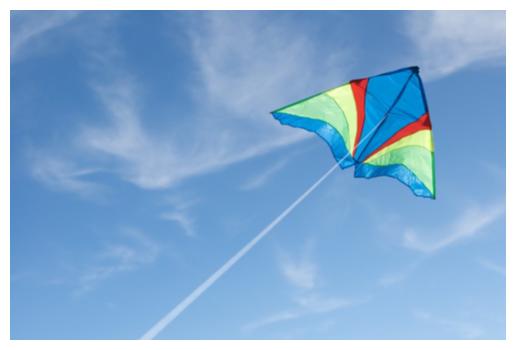

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Foreground


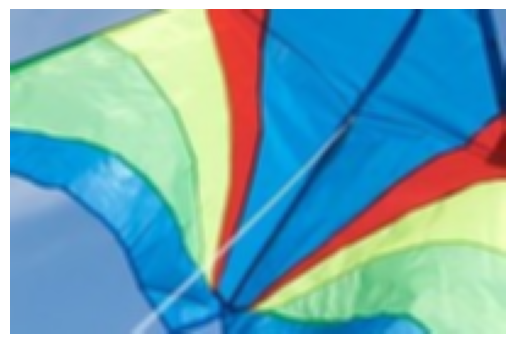

In [37]:
# initalization code

import numpy as np
from matplotlib import pyplot as plt
import cv2

# read images
datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW3/Code/"
im = cv2.imread(datadir + 'kite.jpg')  # this is the full image
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
im = cv2.blur(im, (3, 3))

crop = cv2.imread(datadir + 'kite_crop.jpg')  # this is the cropped image
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255
crop = cv2.blur(crop, (3, 3))

# displays a single image
def display_image(im):
  plt.imshow(im)
  plt.axis('off')
  plt.show()

# displays the image, score map, thresholded score map, and masked image
def display_score(im, score_map, thresh):
  display_image(im)
  display_image(np.reshape(score, (im.shape[:2])))
  plt.imshow(np.reshape(score_map>thresh, (im.shape[0], im.shape[1])), cmap='gray')
  plt.axis('off')
  plt.show()
  display_image(np.tile(np.reshape(score_map>thresh, (im.shape[0], im.shape[1], 1)), (1,1,3))*im)

print('Whole image')
display_image(im)

print('Foreground')
display_image(crop)


#### Method 1 (per channel hist)

In [142]:
import numpy as np
import matplotlib.pyplot as plt


# pdf for 1a
def estimate_discrete_pdf(values, nvalues, prior=1):
    '''
    Estimate P(values=v) for each possible v in (0, nvalues)
    Input:
        values: the values of the data
        nvalues: range of values, such that 0 <= values < nvalues
        prior: initial count used to prevent any value from having zero probability
    Output:
        p[nvalues,]: P(values=v) for each v
    '''

    prob = np.zeros(nvalues) + prior
    # Count occurrences of each value
    for value in values:
        prob[int(value)] += 1
    # Normalize to get probability
    prob /= np.sum(prob)
    return prob

def estimate_channel_pdf(channel_data, bins):
    # Calculate histogram for the channel
    histogram, bin_edges = np.histogram(channel_data, bins=bins, range=(0, 1), density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    return histogram, bin_centers



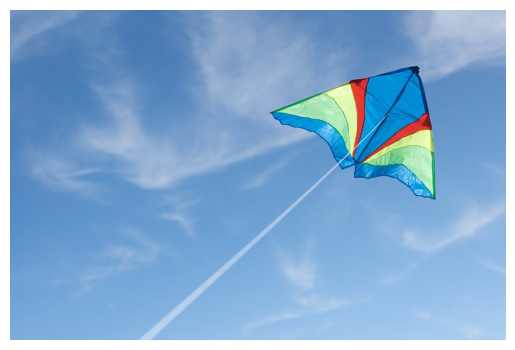

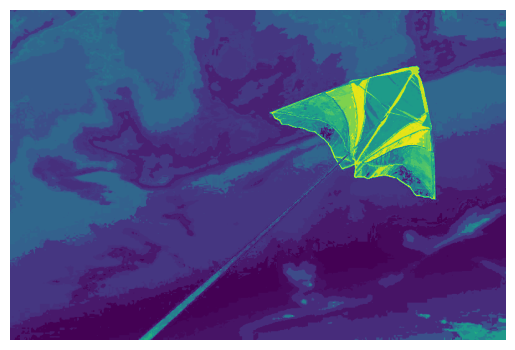

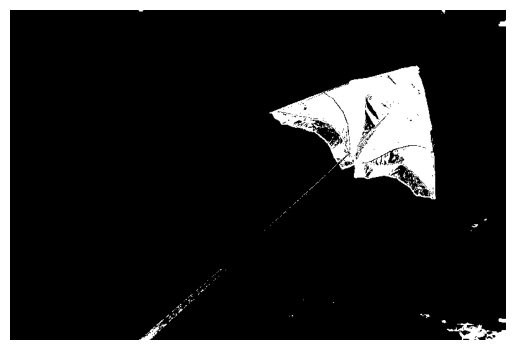

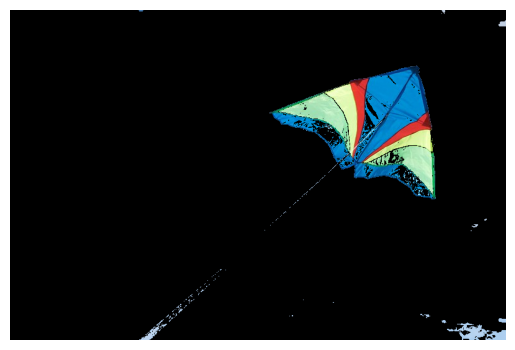

In [153]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


def compute_score(im, crop, bins):
    # Convert image and crop pixels from 0-255 to 0-(bins-1) range
    im_bins = np.floor(im * (bins - 1)).astype(int)
    crop_bins = np.floor(crop * (bins - 1)).astype(int)
    
    score_map = np.zeros(im.shape[:2])
    
    # Estimate PDFs for each color channel and compute score
    for channel in range(3):
        # Estimate PDF for full image and cropped image
        pdf_full = estimate_discrete_pdf(im_bins[:, :, channel].flatten(), bins)
        pdf_crop = estimate_discrete_pdf(crop_bins[:, :, channel].flatten(), bins)
        
        # Compute log likelihood ratio for each pixel in the channel
        score_channel = np.log((pdf_crop[im_bins[:, :, channel]] + 1e-10) / (pdf_full[im_bins[:, :, channel]] + 1e-10))
        
        # Add to the overall score map
        score_map += score_channel.reshape(im.shape[:2])
    
    return score_map


# Estimate PDFs and compute score per pixel
score = compute_score(im, crop, bins=16)

# Display score map and thresholded images
t = 1
display_score(im=im, score_map=score, thresh=t)


#### Method 2 (Kmeans)

In [ ]:
# init
!apt install libomp-dev > /dev/null 2>&1
!pip install faiss-cpu > /dev/null 2>&1
import faiss

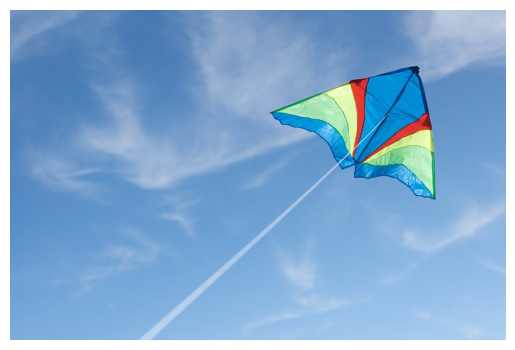

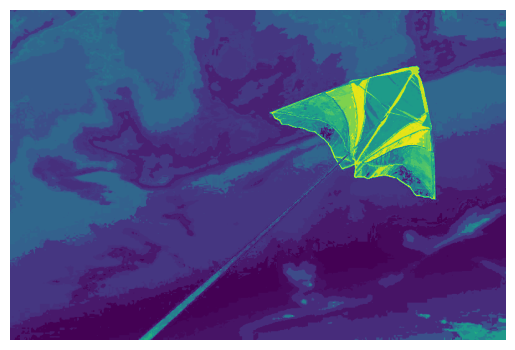

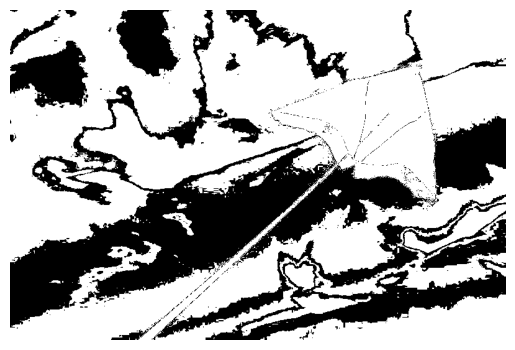

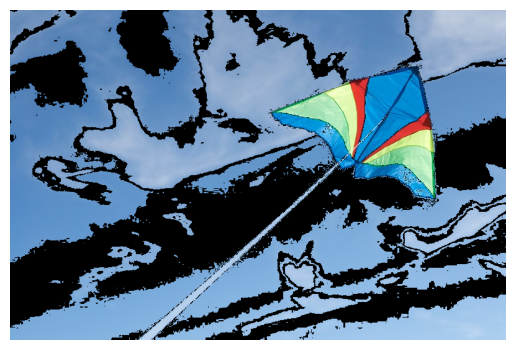

In [175]:

# estimate PDFs and compute score per pixel

# TO DO

# pdf for 1b
def estimate_pdf_from_labels(labels, n_clusters):
    # Count the occurrences of each label (cluster)
    counts = np.bincount(labels, minlength=n_clusters)
    
    # Convert counts to probabilities
    pdf = counts / np.sum(counts)
    
    return pdf


def run_kmeans(data, n_clusters):
    d = data.shape[-1] 
    data = data.reshape(-1, d).astype(np.float32)

    # Initialize and train kmeans
    kmeans = faiss.Kmeans(d, n_clusters, niter=20, verbose=False)
    kmeans.train(data)

    # Assign each vector to the nearest cluster center
    D, I = kmeans.index.search(data, 1)
    return kmeans, I.flatten()

# read images
datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW3/Code/"
im = cv2.imread(datadir + 'kite.jpg') 
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)/255
crop = cv2.imread(datadir + 'kite_crop.jpg') 
crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)/255


n_clusters = 32

im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))

# Run FAISS k-means on the image data
kmeans_im, labels_im = run_kmeans(im_3, n_clusters)
kmeans_crop, labels_crop = run_kmeans(crop_3, n_clusters)

# Estimate the PDFs from the k-means clusters
pdf_full = estimate_pdf_from_labels(labels_im, n_clusters)
pdf_crop = estimate_pdf_from_labels(labels_crop, n_clusters)

# Compute the score per pixel
# Use the cluster labels to index into the PDFs
score_map = np.zeros_like(labels_im, dtype=np.float32)
for i in range(n_clusters):
    mask = labels_im == i
    score_map[mask] = np.log((pdf_crop[i] + 1e-10) / (pdf_full[i] + 1e-10))

score_map_reshaped = score_map.reshape(im.shape[0], im.shape[1])

t = -1
display_score(im, score_map_reshaped, t)


#### Method 3 (GMM)

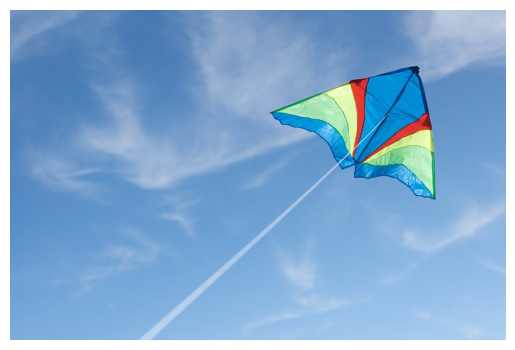

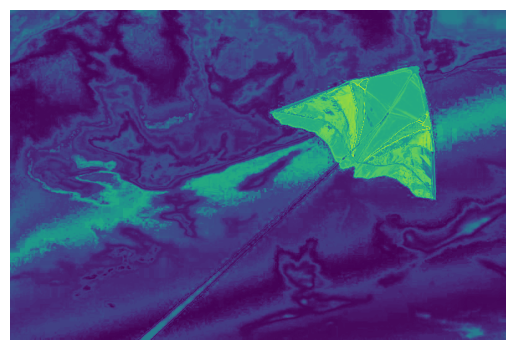

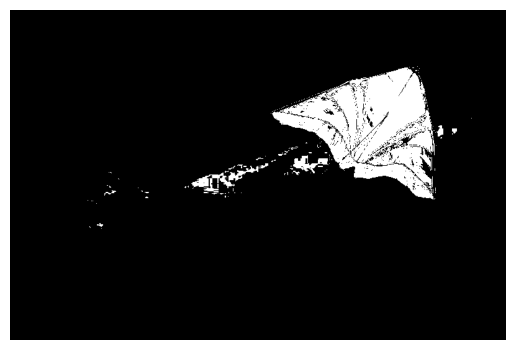

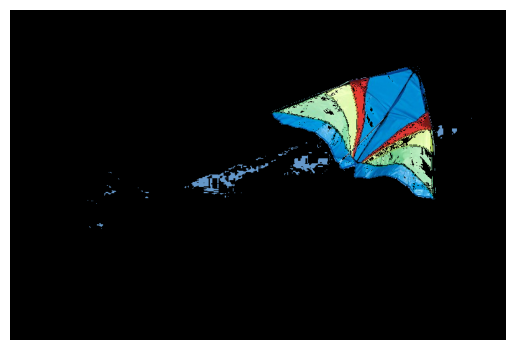

In [190]:
from sklearn.mixture import GaussianMixture

im_3 = np.reshape(im, (im.shape[0]*im.shape[1], 3))
crop_3 = np.reshape(crop, (crop.shape[0]*crop.shape[1], 3))


gmm_full = GaussianMixture(n_components=10, covariance_type='spherical').fit(im_3)

gmm_crop = GaussianMixture(n_components=10, covariance_type='spherical').fit(crop_3)

# Compute the log probabilities (log PDF)
log_prob_full = gmm_full.score_samples(im_3)
log_prob_crop = gmm_crop.score_samples(im_3)

# Compute the score per pixel as the difference in log probabilities
score = log_prob_crop - log_prob_full

# Reshape score to the original image shape for display
score = score.reshape(im.shape[0], im.shape[1])

t = 2
display_score(im=im, score_map=score, thresh=t)


## Part 2: Robust Estimation

In [191]:
import numpy as np
from matplotlib import pyplot as plt

datadir = "/Users/darian/Desktop/UIUC/Applied ML/HW3/Code/"

# load data
T = np.load(datadir + 'salary.npz')
(salary, years, school) = (T['salary'], T['years'], T['school'])

#### 1. No noise
Compute the statistics for the data as a whole

In [86]:
# TO DO
import numpy

salary_mu = np.mean(salary)
salary_std = np.std(salary)
salary_min = np.min(salary)
salary_max = np.max(salary)

print('Mean: {}  Std: {}  Min: {}   Max: {}'.format(salary_mu, salary_std, salary_min, salary_max))

Mean: 123749.835  Std: 61953.77348723623  Min: 64694.0   Max: 611494.0


#### 2. Percentiles
Assume valid data will fall between the 5th and 95th percentile.

In [98]:
import numpy as np
from matplotlib import pyplot as plt

pct_5 = np.percentile(salary, 5)
pct_95 = np.percentile(salary, 95)

salary_min = pct_5 - (pct_95 - pct_5) * 0.05 / 0.9
salary_max = pct_95 + (pct_95 - pct_5) * 0.05 / 0.9

salary_range = salary[(salary >= pct_5) & (salary <= pct_95)]
salary_mu = np.mean(salary_range)
salary_std = np.std(salary_range)

print('Mean: {:.2f}  Std: {:.2f}  Min: {:.2f}   Max: {:.2f}'.format(salary_mu, salary_std, salary_min, salary_max))


Mean: 113878.65  Std: 15876.45  Min: 75493.80   Max: 159900.80


#### 3. EM
Assume valid data follows a Gaussian distribution, while the fake data has a uniform distribution between the minimum and maximum value of salary.

In [136]:
import numpy as np

niter = 20

N = 1
M = len(salary)

salary_mean = np.mean(salary).reshape((1, 1)) 
salary_std = np.sqrt(np.sum((salary - salary_mean) ** 2) / N/M)  

pz = 0.5 

for t in range(niter):
    # E-step: Calculate the probability of each salary being valid
    # Assuming Gaussian distribution for valid data and uniform distribution for invalid data
    prob_valid = pz * (1 / (np.sqrt(2 * np.pi) * salary_std)) * np.exp(-0.5 * ((salary - salary_mean) / salary_std) ** 2)
    prob_invalid = (1 - pz) * (1 / (salary.max() - salary.min()))
    p_valid_given_salary = prob_valid / (prob_valid + prob_invalid)
    
    # M-step: Update estimates for mean, standard deviation, and pz
    salary_mean = np.sum(p_valid_given_salary * salary) / np.sum(p_valid_given_salary)
    salary_std = np.sqrt(np.sum(p_valid_given_salary * (salary - salary_mean) ** 2) / np.sum(p_valid_given_salary))
    pz = np.mean(p_valid_given_salary)

    
# Calculating min and max salaries based on the valid data range
salary_min = np.min(salary[p_valid_given_salary>0.5])
salary_max = np.max(salary[p_valid_given_salary>0.5])

print('Mean: {:.2f}'.format(salary_mean))
print('Std: {:.2f}'.format(salary_std))
print('Min: {:.2f}'.format(salary_min))
print('Max: {:.2f}'.format(salary_max))

invalid_indices = np.where(p_valid_given_salary < 0.5)[0][:5]
print('Indices of likely invalid salaries:', invalid_indices)


Mean: 111984.38
Std: 17966.36
Min: 64694.00
Max: 169008.00
Indices of likely invalid salaries: [ 18  28  49 127 128]


## Part 3: Stretch Goals
Include all your code used for any stretch goals in this section. Add headings where appropriate.

## 3a

In [141]:
import numpy as np


num_schools = 3
niter = 20
pz = 0.015  # assuming 3 invalid entries in the dataset of 200 entries

# Initial estimates
salary_means = np.array([np.mean(salary[school == i]) if i in school else np.mean(salary) for i in range(num_schools)])
salary_std = np.std(salary)

# Placeholder
p_school_given_salary = np.zeros((len(salary), num_schools))

for j in range(niter):
    # E-step: Update probabilities for missing school assignments
    for i in range(num_schools):
        prob_valid = pz * (1 / (np.sqrt(2 * np.pi) * salary_std)) * np.exp(-0.5 * ((salary - salary_means[i]) / salary_std) ** 2)
        p_school_given_salary[:, i] = prob_valid
    
    # Normalize
    p_school_given_salary /= p_school_given_salary.sum(axis=1, keepdims=True)
    
    # M-step: Update mean salary for each school
    for i in range(num_schools):
        # Update using both known and estimated assignments
        weights = p_school_given_salary[:, i] + (school == i)
        salary_means[i] = np.sum(weights * salary) / np.sum(weights)
    
    # Update overall standard deviation based on new means
    weighted_sums = np.sum([p_school_given_salary[:, i] * (salary - salary_means[i])**2 for i in range(num_schools)], axis=0)
    salary_std = np.sqrt(np.sum(weighted_sums) / len(salary))

# Calculate overall mean salary
overall_mean_salary = np.mean(salary)

print("Overall Mean Salary: {:.2f}".format(overall_mean_salary))
for i in range(num_schools):
    print("Mean Salary for School {}: {:.2f}".format(i, salary_means[i]))


Overall Mean Salary: 123749.84
Mean Salary for School 0: 122966.89
Mean Salary for School 1: 123893.12
Mean Salary for School 2: 127568.09


## 3b

In [196]:
import numpy as np

# 'p_school_given_salary' is a matrix of shape (len(salary), num_schools) from the EM algorithm

num_schools = 200 
salary_increases = []

# Iterate over each school
for school_id in range(num_schools):
    # Filter data for the current school based on the highest probability from the EM algorithm
    school_filter = np.argmax(p_school_given_salary, axis=1) == school_id
    
    # Extract salary and years for the filtered data
    filtered_salary = salary[school_filter]
    filtered_years = years[school_filter]
    
    # Calculate differences only within filtered data
    for i in range(len(filtered_salary)-1):
        for j in range(i+1, len(filtered_salary)):
            year_diff = filtered_years[j] - filtered_years[i]
            salary_diff = filtered_salary[j] - filtered_salary[i]
            
            # Only consider positive year differences to calculate the increase per year
            if year_diff > 0:
                salary_increases.append(salary_diff / year_diff)

# Calculate the weighted average of salary increases: considers all pairwise differences within the data filtered by school probability
if salary_increases:
    expected_increase_per_year = np.mean(salary_increases)
else:
    expected_increase_per_year = 0

print("Expected increase in salary per year of experience: {:.2f}".format(expected_increase_per_year))


Expected increase in salary per year of experience: 837.63


## 3c

In [197]:
import numpy as np
from sklearn.metrics import mutual_info_score

# Example data
data = np.array([
    [59, 2, 32.1, 101, 157, 93.2, 38, 4, 4.8598, 87, 151],
    [48, 1, 21.6, 87, 183, 103.2, 70, 3, 3.8918, 69, 75],
    [72, 2, 30.5, 93, 156, 93.6, 41, 4, 4.6728, 85, 141],
    [24, 1, 25.3, 84, 198, 131.4, 40, 5, 4.8903, 89, 206]
])

age = data[:, 0]
sex = data[:, 1]


mutual_info = mutual_info_score(age, sex)

print(f"The mutual information between AGE and SEX is: {mutual_info}")


The mutual information between AGE and SEX is: 0.6931471805599452


In [ ]:
# from https://gist.github.com/jonathanagustin/b67b97ef12c53a8dec27b343dca4abba
# install can take a minute

import os
# @title Convert Notebook to PDF. Save Notebook to given directory
NOTEBOOKS_DIR = "/content/drive/My Drive/CS441/24SP/hw2" # @param {type:"string"}
NOTEBOOK_NAME = "CS441_SP24_HW2_Solution.ipynb" # @param {type:"string"}
#------------------------------------------------------------------------------#
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)
NOTEBOOK_PATH = f"{NOTEBOOKS_DIR}/{NOTEBOOK_NAME}"
assert os.path.exists(NOTEBOOK_PATH), f"NOTEBOOK NOT FOUND: {NOTEBOOK_PATH}"
!apt install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic > /dev/null 2>&1
!jupyter nbconvert "$NOTEBOOK_PATH" --to pdf > /dev/null 2>&1
NOTEBOOK_PDF = NOTEBOOK_PATH.rsplit('.', 1)[0] + '.pdf'
assert os.path.exists(NOTEBOOK_PDF), f"ERROR MAKING PDF: {NOTEBOOK_PDF}"
print(f"PDF CREATED: {NOTEBOOK_PDF}")